# ANALISIS Y PROCESAMIENTO DEL DATAFRAME

In [1]:
import pandas as pd

# Función para obtener la estación del año
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    return None

# Cargar el dataset
dataset = pd.read_csv('./games_data_processed.csv', sep=',', usecols=lambda column: column not in ['steamId', 'developers', 'features', 'tags'])

# Copia del DataFrame
df = dataset.copy()

# Eliminación de duplicados y valores nulos
df.drop_duplicates(keep=False, inplace=True)
df.dropna(subset=['releaseDate'], inplace=True)

# Filtrar juegos con menos de 100k ventas y mayores a 30m ventas
df = df[(df['copiesSold'] >= 100000) & (df['copiesSold'] <= 30000000)]

# Relacionar publishers con la cantidad de copias vendidas
publisher_review_counts = df.groupby('publishers')['copiesSold'].mean().reset_index()
publisher_review_counts.columns = ['publishers', 'avg_publisher_copies']

# Unir el DataFrame original con los conteos de ventas promedio por publisher
df = df.merge(publisher_review_counts, on='publishers', how='left')

# Eliminar publishers que no tienen suficientes datos
df = df[df['avg_publisher_copies'].notna()]

# Convertir las fechas y extraer año y mes
df['releaseDate'] = pd.to_datetime(df['releaseDate'], format='%m/%Y', errors='coerce')

# Extraer año y mes, luego calcular la estación
df['year'] = df['releaseDate'].dt.year
df['month'] = df['releaseDate'].dt.month
df['season'] = df['month'].apply(get_season)

current_year = pd.Timestamp.now().year
df['years_since_release'] = current_year - df['year']

# Eliminar columnas no necesarias
df = df.drop(['releaseDate', 'month'], axis=1)

def calculate_popularity(game_row):
    score = 0
    score += game_row['reviews'] * 0.1  # Menor peso para reseñas
    score += game_row['reviewScore'] * 0.1  # Menor peso para puntuación de reseñas
    score += game_row['copiesSold'] * 0.3  # Peso mediano para copias vendidas
    score += game_row['years_since_release'] * 0.5  # Mayor peso para años desde el lanzamiento
    return score

# Normalizar la columna de popularidad
df['popularity'] = df.apply(calculate_popularity, axis=1)

# Revisar la distribución de popularidad y ajustar los cortes de qcut
print(df['popularity'].describe())
df['popularity'] = pd.qcut(df['popularity'], 4, labels=[1, 2, 3, 4])

# Filtrar géneros no deseados
undesired_genres = ['Accounting', 'Animation & Modeling', 'Audio Production', 'Design & Illustration', 'Game Development', 'Movie', 'Software Training', 'Utilities', 'Video Production', 'Web Publishing']
for genre in undesired_genres:
    df = df[~df['genres'].str.contains(genre, case=False)]

# Codificar géneros
genres_encoded = df['genres'].str.replace(', ', '|').str.get_dummies()
df = pd.concat([df, genres_encoded], axis=1)
df = df.drop('genres', axis=1)

# Guardar el DataFrame refinado
#df.to_csv('games_data_refined.csv', index=False)
#print("El DataFrame refinado ha sido guardado como 'games_data_refined.csv'.")

print("Dataset procesado \n")
df.head()


count    4.419000e+03
mean     2.255106e+05
std      4.289963e+05
min      3.011660e+04
25%      4.801250e+04
50%      8.702990e+04
75%      2.134555e+05
max      6.114029e+06
Name: popularity, dtype: float64
Dataset procesado 



,name,price,reviews,reviewScore,copiesSold,publishers,avg_publisher_copies,year,season,years_since_release,...,Casual,Early Access,Free to Play,Indie,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
0,STAR WARS™: The Old Republic™,0.00,61722,90,3565446,Electronic Arts,1.221779e+06,2020,Summer,4,...,0,0,1,0,1,1,0,0,0,0
1,Crusader Kings III,49.99,99754,92,2483771,Paradox Interactive,1.036797e+06,2020,Fall,4,...,0,0,0,0,0,1,0,1,0,1
2,Half-Life: Alyx,59.99,84732,98,1986703,Valve,2.727963e+06,2020,Spring,4,...,0,0,0,0,0,0,0,0,0,0
3,NieR:Automata™,39.99,121866,86,2945349,Square Enix,7.331162e+05,2017,Spring,7,...,0,0,0,0,0,1,0,0,0,0
4,V Rising,34.99,83596,89,4739489,Stunlock Studios,2.891558e+06,2024,Spring,0,...,0,0,0,0,1,0,0,0,0,0


In [2]:
len(df)

4417

In [3]:
df.columns

Index(['name', 'price', 'reviews', 'reviewScore', 'copiesSold', 'publishers',
       'avg_publisher_copies', 'year', 'season', 'years_since_release',
       'popularity', 'Action', 'Adventure', 'Casual', 'Early Access',
       'Free to Play', 'Indie', 'Massively Multiplayer', 'RPG', 'Racing',
       'Simulation', 'Sports', 'Strategy'],
      dtype='object')

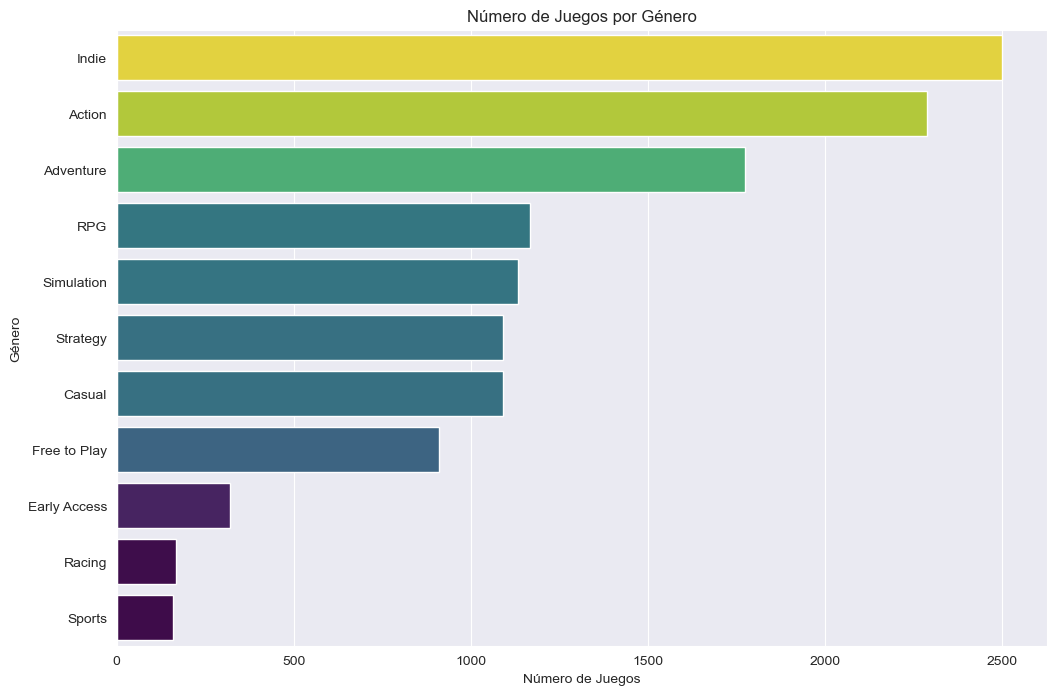

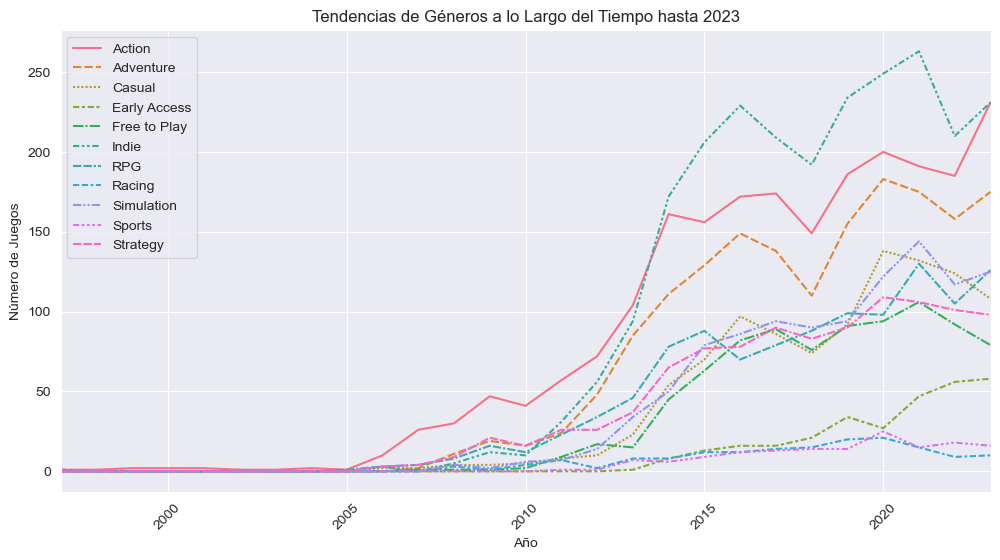

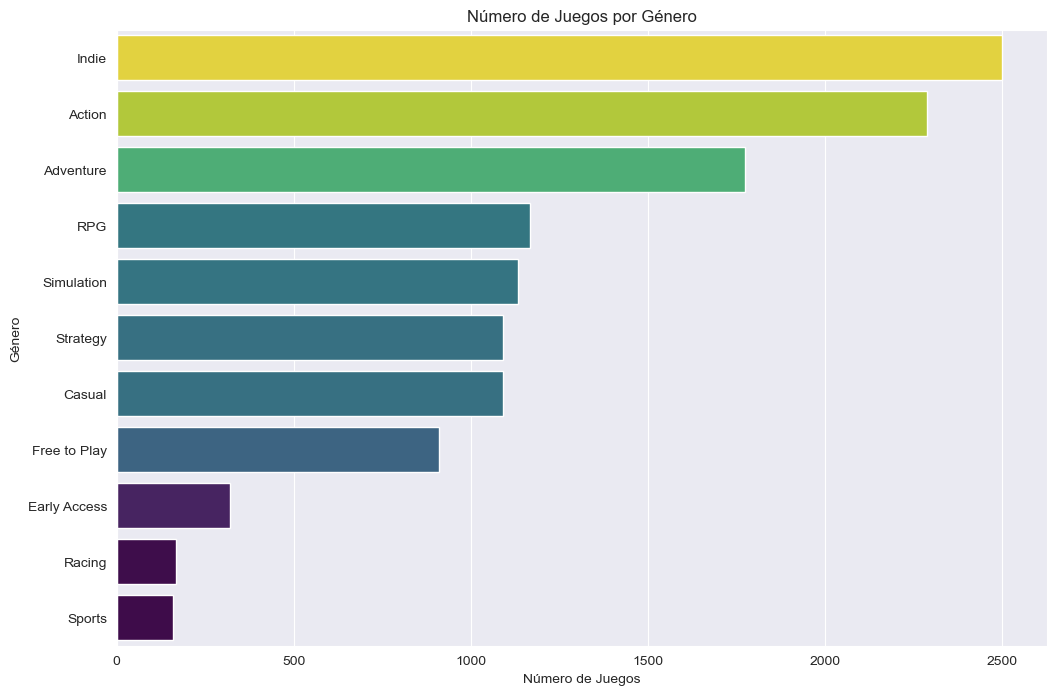

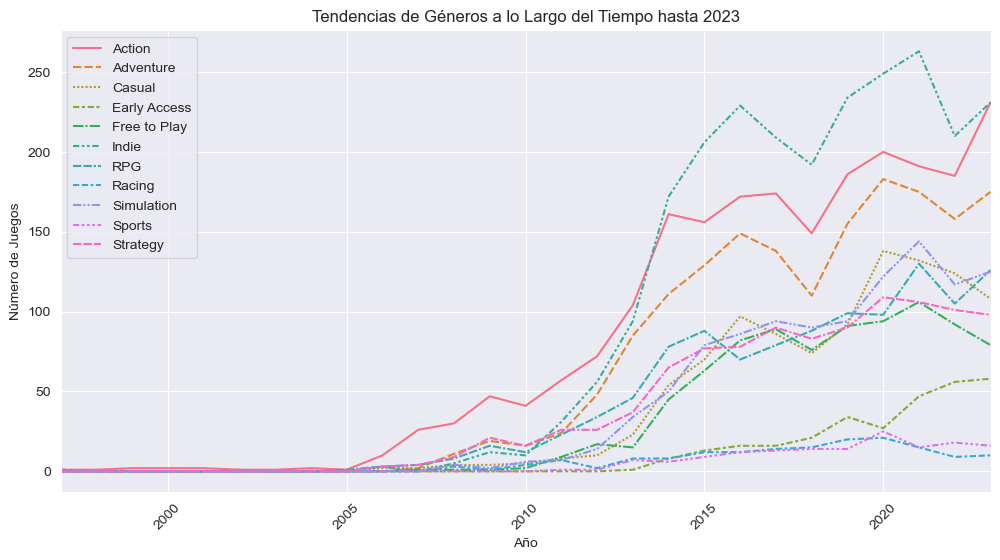

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por géneros y contar la cantidad de juegos
genre_columns = ['Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 
                  'Indie', 'RPG', 'Racing', 'Simulation', 'Sports', 'Strategy']

# Sumar juegos por cada género
genre_counts = df[genre_columns].sum().sort_values(ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por géneros y contar la cantidad de juegos
genre_columns = ['Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 
                  'Indie', 'RPG', 'Racing', 'Simulation', 'Sports', 'Strategy']

# Sumar juegos por cada género
genre_counts = df[genre_columns].sum().sort_values(ascending=False)

# Crear un DataFrame para visualizar
genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ['Genre', 'Count']


# 1. Distribución de Géneros

#Visualización de la cantidad de juegos por género
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Genre', hue='Count', data=genre_counts_df, palette="viridis", legend=False)
plt.title('Número de Juegos por Género')
plt.xlabel('Número de Juegos')
plt.ylabel('Género')
plt.show()

# 2. Tendencias Temporales de Géneros
# Filtrar los datos para que solo incluyan hasta el año 2023
df_filtered = df[df['year'] <= 2023]
genres_over_time = df_filtered.groupby(['year'])[genre_columns].sum()  # Agrupar por año, excluyendo las columnas no deseadas

plt.figure(figsize=(12, 6))
sns.lineplot(data=genres_over_time)
plt.title('Tendencias de Géneros a lo Largo del Tiempo hasta 2023')
plt.ylabel('Número de Juegos')
plt.xlabel('Año')
plt.xticks(rotation=45)
plt.xlim(df_filtered['year'].min(), 2023)  # Asegurarse de que el eje x termine en 2023
plt.show()

# Crear un DataFrame para visualizar
genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ['Genre', 'Count']


# 1. Distribución de Géneros

#Visualización de la cantidad de juegos por género
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Genre', hue='Count', data=genre_counts_df, palette="viridis", legend=False)
plt.title('Número de Juegos por Género')
plt.xlabel('Número de Juegos')
plt.ylabel('Género')
plt.show()

# 2. Tendencias Temporales de Géneros
# Filtrar los datos para que solo incluyan hasta el año 2023
df_filtered = df[df['year'] <= 2023]
genres_over_time = df_filtered.groupby(['year'])[genre_columns].sum()  # Agrupar por año, excluyendo las columnas no deseadas

plt.figure(figsize=(12, 6))
sns.lineplot(data=genres_over_time)
plt.title('Tendencias de Géneros a lo Largo del Tiempo hasta 2023')
plt.ylabel('Número de Juegos')
plt.xlabel('Año')
plt.xticks(rotation=45)
plt.xlim(df_filtered['year'].min(), 2023)  # Asegurarse de que el eje x termine en 2023
plt.show()


# PROCESO FUZZIFICACION

Popularidad difusa por género:
                   low  medium      high most_popular
Action        0.072958     0.6  0.211737       medium
Adventure     0.106254     0.6  0.156244       medium
Casual        0.141835     0.6  0.096942       medium
Early Access  0.117500     0.6  0.137500       medium
Free to Play  0.082327     0.6  0.196121       medium
Indie         0.126379     0.6  0.122702       medium
RPG           0.101799     0.6  0.163668       medium
Racing        0.137278     0.6  0.104536       medium
Simulation    0.108738     0.6  0.152104       medium
Sports        0.118239     0.6  0.136268       medium
Strategy      0.107608     0.6  0.153987       medium


<Figure size 1000x800 with 0 Axes>

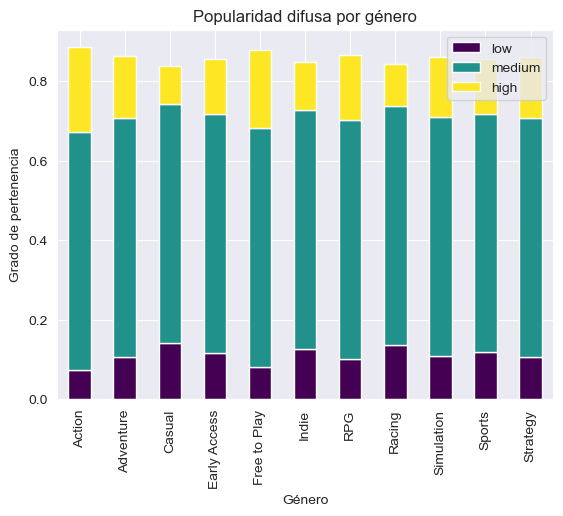

Lista de los géneros más populares en el año:
Género: Action, Popularidad: 1.91, Nivel: Medium
Género: Free to Play, Popularidad: 1.87, Nivel: Medium
Género: RPG, Popularidad: 1.79, Nivel: Medium
Género: Adventure, Popularidad: 1.77, Nivel: Medium
Género: Strategy, Popularidad: 1.77, Nivel: Medium
Género: Simulation, Popularidad: 1.77, Nivel: Medium
Género: Early Access, Popularidad: 1.73, Nivel: Medium
Género: Sports, Popularidad: 1.73, Nivel: Medium
Género: Indie, Popularidad: 1.69, Nivel: Medium
Género: Racing, Popularidad: 1.65, Nivel: Medium
Género: Casual, Popularidad: 1.63, Nivel: Medium


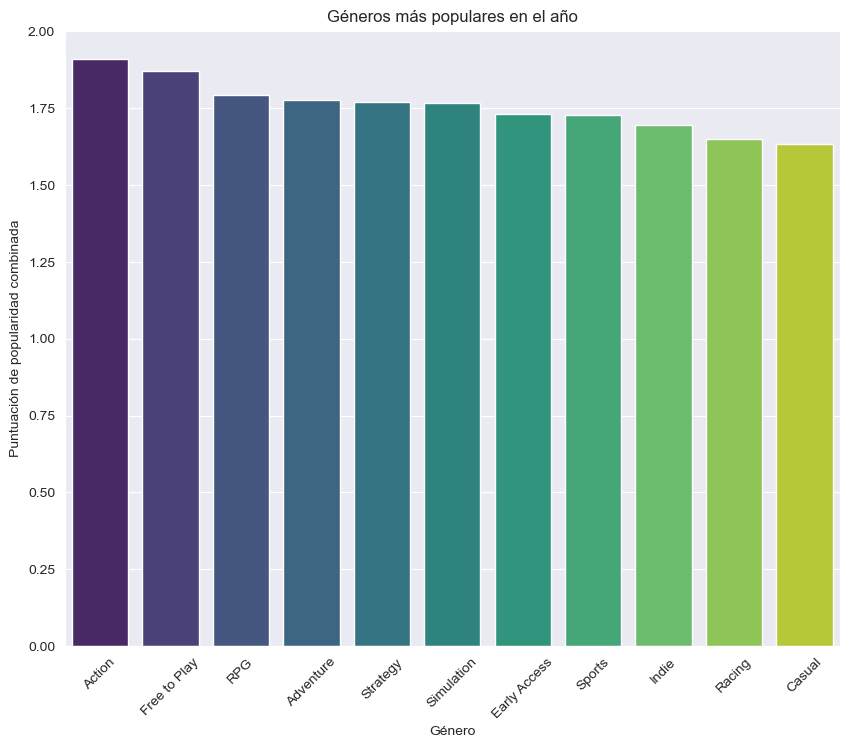

In [5]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo las columnas de géneros y la columna de popularidad
genre_columns = ['Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 'Indie',
                  'RPG', 'Racing', 'Simulation', 'Sports', 'Strategy']
df_genres = df[genre_columns + ['popularity']]

# Ajustar las funciones de pertenencia para la popularidad
x_popularity = np.arange(1, 5, 1)  # Mantendremos 4 niveles por ahora
low = fuzz.trimf(x_popularity, [1, 1, 2.25])
medium = fuzz.trimf(x_popularity, [1.25, 2.5, 3.75])
high = fuzz.trimf(x_popularity, [2.5, 4, 4])

# Crear un DataFrame para almacenar la popularidad difusa por género
fuzzy_popularity_by_genre = pd.DataFrame(index=genre_columns, columns=['low', 'medium', 'high'])

# Calcular los grados de pertenencia para cada género
for genre in genre_columns:
    genre_popularity = df_genres[df_genres[genre] == 1]['popularity'].astype(float)
    
    if genre_popularity.empty:
        continue  # Saltar géneros sin datos
    
    genre_popularity_mean = genre_popularity.mean()

    # Calcular los grados de pertenencia
    fuzzy_popularity_by_genre.loc[genre, 'low'] = fuzz.interp_membership(x_popularity, low, genre_popularity_mean)
    fuzzy_popularity_by_genre.loc[genre, 'medium'] = fuzz.interp_membership(x_popularity, medium, genre_popularity_mean)
    fuzzy_popularity_by_genre.loc[genre, 'high'] = fuzz.interp_membership(x_popularity, high, genre_popularity_mean)

# Identificar el nivel de popularidad más alto para cada género
fuzzy_popularity_by_genre['most_popular'] = fuzzy_popularity_by_genre[['low', 'medium', 'high']].idxmax(axis=1)



# Reemplazar valores NaN por 0
pd.set_option('future.no_silent_downcasting', True)
fuzzy_popularity_by_genre = fuzzy_popularity_by_genre.fillna(0)



# Inferir tipos de datos correctos
fuzzy_popularity_by_genre = fuzzy_popularity_by_genre.infer_objects()

# Mostrar la popularidad difusa por género
print("Popularidad difusa por género:")
print(fuzzy_popularity_by_genre)

# Visualización
plt.figure(figsize=(10, 8))
fuzzy_popularity_by_genre[['low', 'medium', 'high']] = fuzzy_popularity_by_genre[['low', 'medium', 'high']].astype(float)
fuzzy_popularity_by_genre[['low', 'medium', 'high']].plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Popularidad difusa por género')
plt.xlabel('Género')
plt.ylabel('Grado de pertenencia')
plt.legend(loc='upper right')
plt.show()

# Crear una métrica de popularidad combinada
fuzzy_popularity_by_genre['popularity_score'] = (
    fuzzy_popularity_by_genre['low'] * 1 +
    fuzzy_popularity_by_genre['medium'] * 2 +
    fuzzy_popularity_by_genre['high'] * 3
)

# Ordenar géneros por popularidad combinada
fuzzy_popularity_by_genre_sorted = fuzzy_popularity_by_genre.sort_values(by='popularity_score', ascending=False)

# Presentación textual
print("Lista de los géneros más populares en el año:")
for idx, row in fuzzy_popularity_by_genre_sorted.iterrows():
    print(f"Género: {idx}, Popularidad: {row['popularity_score']:.2f}, Nivel: {row['most_popular'].capitalize()}")

# Visualización gráfica
plt.figure(figsize=(10, 8))

sns.barplot(x='index', y='popularity_score', hue='index', data=fuzzy_popularity_by_genre_sorted.reset_index(), palette="viridis", legend=False)
plt.title('Géneros más populares en el año')
plt.xlabel('Género')
plt.ylabel('Puntuación de popularidad combinada')
plt.xticks(rotation=45)
plt.show()


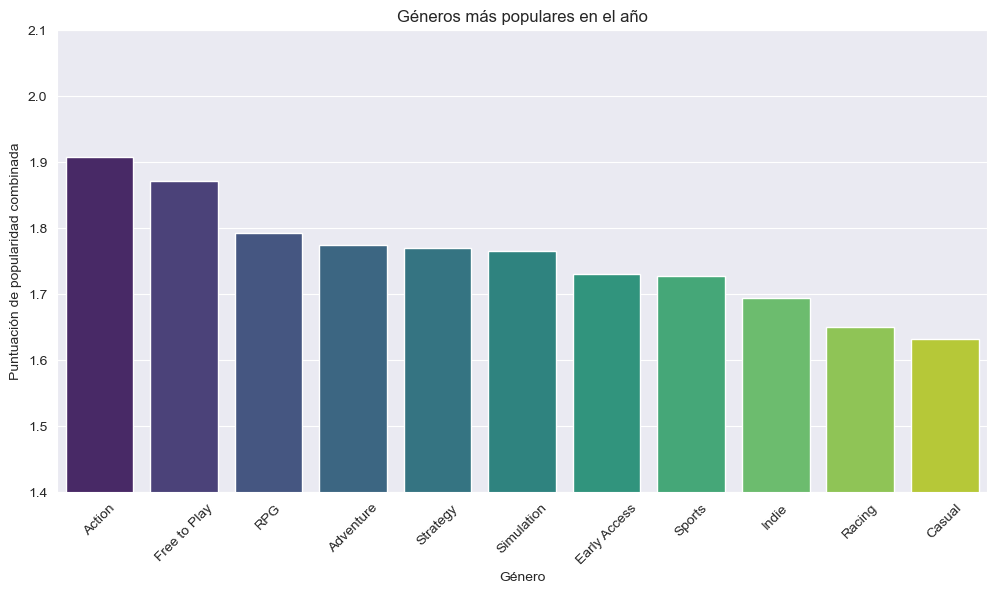

In [6]:
# Solución para evitar el warning y mejorar la visualización del gráfico
plt.figure(figsize=(12, 6))

sns.barplot(x='index', y='popularity_score', hue='index', data=fuzzy_popularity_by_genre_sorted.reset_index(), palette="viridis", legend=False)
plt.title('Géneros más populares en el año')
plt.xlabel('Género')
plt.ylabel('Puntuación de popularidad combinada')

# Mejorar la escala del eje Y para apreciar mejor la diferencia entre los géneros
plt.ylim(1.4, 2.1)

# Rotar las etiquetas de los géneros para mejor legibilidad
plt.xticks(rotation=45)

plt.show()


# DEFUZZIFICACION

Valores defuzzificados de popularidad por género:
              defuzzified_popularity
Action                      2.656867
Free to Play                2.629540
RPG                         2.571485
Adventure                   2.557960
Strategy                    2.553830
Simulation                  2.550376
Early Access                2.523392
Sports                      2.521099
Indie                       2.495669
Racing                      2.461106
Casual                      2.446478


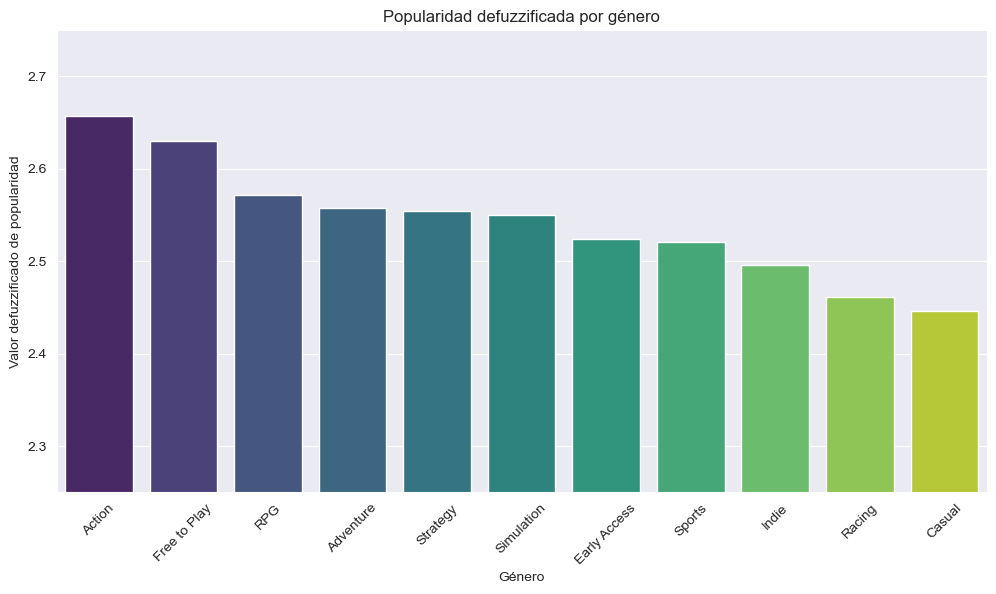

In [7]:
# Defuzzificación usando el método del centroide

# Crear un diccionario para almacenar los valores defuzzificados
defuzzified_values = {}

# Calcular el valor defuzzificado para cada género
for genre in genre_columns:
    low_value = fuzzy_popularity_by_genre.loc[genre, 'low']
    medium_value = fuzzy_popularity_by_genre.loc[genre, 'medium']
    high_value = fuzzy_popularity_by_genre.loc[genre, 'high']
    
    # Método del centroide (suma ponderada de los valores)
    numerator = (low_value * 1.5) + (medium_value * 2.5) + (high_value * 3.5)
    denominator = low_value + medium_value + high_value
    defuzzified_value = numerator / denominator if denominator != 0 else 0
    
    defuzzified_values[genre] = defuzzified_value

# Convertir el diccionario a un DataFrame para una mejor visualización
defuzzified_df = pd.DataFrame.from_dict(defuzzified_values, orient='index', columns=['defuzzified_popularity'])

# Ordenar los géneros por el valor defuzzificado
defuzzified_df_sorted = defuzzified_df.sort_values(by='defuzzified_popularity', ascending=False)

# Mostrar los valores defuzzificados
print("Valores defuzzificados de popularidad por género:")
print(defuzzified_df_sorted)

# Añadir una columna para hue
defuzzified_df_sorted['hue'] = defuzzified_df_sorted.index

# Visualización gráfica de los valores defuzzificados
plt.figure(figsize=(12, 6))

sns.barplot(x=defuzzified_df_sorted.index, y='defuzzified_popularity', data=defuzzified_df_sorted, hue='hue', palette="viridis")
plt.title('Popularidad defuzzificada por género')
plt.xlabel('Género')
plt.ylabel('Valor defuzzificado de popularidad')
plt.xticks(rotation=45)
plt.ylim(2.25, 2.75)
plt.show()
